<h1><center>Restricted Boltzmann Machines for Collaborative Filtering</center></h1>

##  Pre-processing phase

In [1]:
 
import numpy as np  
import pandas as pd 
import torch 
import matplotlib.pyplot as plt


### 1 Dataset

We are using the MovieLens 1M dataset. This set contains 1 million notes from approximately 3,952 films rated by 6,040 users.
The model will be trained on this dataset and learn to make predictions to give a random user a set of specified movies. The dataset requires preprocessing steps.

#### 1-1 Movies.dat

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [2]:
#Chargement du dataset qui contient les informations sur chaque film

movies_df = pd.read_csv('movies.dat', sep='::', header=None, engine='python')
movies_df.columns = ['MovieID', 'Title', 'Genres']

#On ajoute une indexation pour chaque film vu que le nombre total est 3883 et id du dernier film est 3952
movies_df['List Index'] = movies_df.index
movies_df.head()



,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


#### 1-2 Rating.dat

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [3]:
# Chargement du dataset qui contient les notes attribuer au films par utilisateur  

ratings_df = pd.read_csv('ratings.dat', sep='::', header=None, engine='python')
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

#Suppression des colonnes inutiles
ratings_df = ratings_df.drop('Timestamp', axis=1)
ratings_df.head()


,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [80]:
# on peut modifier le nombre des utilisateurs et le nombre des films 
nb_user = 6040
nb_movie = 3952
fusion  = movies_df.merge(ratings_df, on='MovieID')
fusion = fusion[(fusion['List Index'] < nb_movie) & (fusion['UserID'] <= nb_user) ]

fusion.head()

,MovieID,Title,Genres,List Index,UserID,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,0,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,0,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,0,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,0,10,5


### 2 Dataset manipulation

Restricted Boltzmann machine only accepts binary values, it is necessary to assign a value of 0 or 1 (to like, not to like), we suppose that not to like a film is equivalent to a rate of 1 or 2, and liking a film is equivalent to giving a rating of 3, 4 or 5. <br>
But this binary notion makes us lose a lot of information. To improve the quality of the result we will do normalization of the ratings, divide each rating by 5. We consider in this case that if a user has not seen a film, a rating of 0 (0 does not mean that he has not liked the movie).


In [81]:

def transform(data):
    dataT = []
    for id_user in range(1,nb_user+1):
        #Séléctioner les films de l'utilisateur courant
        id_film = data['List Index'][ id_user == data['UserID'] ]
        
        #Séléctioner les notes attribuées par l'utilisateur courant
        id_note = data['Rating'][ id_user == data['UserID'] ]
        
        #Initialiser tout à zero  si un utilisateur n’a pas vu un film une note 0
        note = np.zeros(nb_movie)
        
        #Normaliser les notes 
        note[id_film -1] = id_note/5 
        dataT.append(list(note))
    return dataT

# la liste base contient tout les utilisateurs en ligne et les films en colonne
base = transform(fusion)


### 3 Splitting data

   ### Original
|.     |Movie 1| Movie 2| Movie 3| Movie 5| Movie 6| Movie 7| Movie 8| Movie 9|
|------|-------|--------|--------|--------|--------|--------|--------|--------|
|User 1 | 0.8|0.2|0.8|0.4|0.0|0.0|0.6|0.2|0.0|1.0|1.0|
|User 2 | 0.4|0.4|0.2|0.0|0.0|0.6|0.4|0.4|0.2|1.0|0.0|
|User 3 | 0.0|0.2|0.2|0.2|0.0|1.0|1.0|0.6|0.8|0.4|0.0|

   ### Train
|.     |Movie 1| Movie 2| Movie 3| Movie 5| Movie 6| Movie 7| Movie 8| Movie 9|
|------|-------|--------|--------|--------|--------|--------|--------|--------|
|User 1 | 0.8|0.2|0.8|0.0|0.0|0.0|0.0|0.2|0.0|1.0|1.0|
|User 2 | 0.4|0.4|0.2|0.0|0.0|0.6|0.4|0.0|0.0|0.0|0.0|
|User 3 | 0.0|0.2|0.2|0.0|0.0|1.0|0.0|0.6|0.8|0.4|0.0|

   ### Test
|.     |Movie 1| Movie 2| Movie 3| Movie 5| Movie 6| Movie 7| Movie 8| Movie 9|
|------|-------|--------|--------|--------|--------|--------|--------|--------|
|User 1 | 0.0|0.0|0.0|0.4|0.0|0.0|0.6|0.0|0.0|0.0|0.0|
|User 2 | 0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.2|1.0|0.0|
|User 3 | 0.0|0.0|0.0|0.2|0.0|0.0|1.0|0.0|0.0|0.0|0.0|


In [82]:
l_nnzeros=[]
# Pourcentage de donnée de test 20%
per=.2 
for i in range(len(base)):
    c=0
    for j in range(len(base[i])):
        if base[i][j]!=0:
            c=c+1   
    l_nnzeros.append(c)
    
l_per= [int(i*per) for i in l_nnzeros]
l_train=np.copy(base)
for i in range(len(base)):
    cpt=1
    for j in range(len(base[i])):
        if base[i][j]!=0 and cpt<=l_per[i]:
            l_train[i][j]=0
            cpt=cpt+1
            
l_test=base-l_train
        
l_train=list(l_train)
l_test=list(l_test)

## Transformation des données sous forme de tensor
base = torch.FloatTensor(base) #original data
base_train = torch.FloatTensor(l_train) #train data
base_test = torch.FloatTensor(l_test) #test 

## Implementation phase


   La méthode RBM prend un vecteur en entrée, et à l’intérieur de ce vecteur, elle prédira les notes attribuées aux films 
    qui n’ont pas été évalués à l’origine par l’utilisateur. Mais puisque ces notations prédictives sont calculées à partir
    des notations existantes du vecteur d'entrée, les notations prédites dans la sortie doivent avoir le même format que 
    les notations existantes dans l'entrée. Sinon, les choses seraient incohérentes pour le RBM.
    
   The RBM method takes an input vector, and inside this vector, it will predict the ratings assigned to the films
     that were not originally evaluated by the user. But since these predictive ratings are calculated from
     existing notations of the input vector, the predicted notations in the output must have the same format as
     the existing notations in the entry. Otherwise, things would be inconsistent with the RBM.
    
    

### 1- RBM class

   To implement the RBM class, we'll be performing the three following steps:
     - Initialization of the weights.
     - Gibbs sampling
     - Contrastive Divergence

#### 1-1 __ init__()

The constructor defines the initializations for the weights and the biases. The weights are distributed normally while the biases are all set to zero at the start.

#### 1-2 Echan_h()

Depending on an input X, the following function obtains the probabilities that a hidden neuron is activated. This is obtained by multiplying the input V by the weighting matrix, by adding the bias corresponding to this layer and by applying a sigmoidal activation. The probabilities obtained are used for sampling from the Bernoulli distribution and using the Relu activation function as indicated in the function. This formula was obtained after several tests, and it has given us good results.

#### 1-3 Echan_v()

Given the hidden states H, we can use them to obtain the probabilities that a visible neuron is active as well as the corresponding state values. This is obtained by multiplying H by the weighting matrix, adding the bias corresponding to this layer and applying a sigmoidal activation. The probabilities obtained are used to sample.
The two methods Echan_h and Echan_v will allow us thereafter to do Gibbs Sampling.

#### 1-4 Train()

The values obtained in the previous steps can be used to calculate the gradient matrix and the gradient vectors.

In [102]:

class RBM():
    def __init__ (self , nv , nh) : #nv: nombre de neurone visible nh: nombre de neurone caché
        self.W  = torch.randn(nh,nv)*0.01 #learning rate
        self.bv = torch.zeros(1 ,nh) # bias bv: visible  --> hidden
        self.bh = torch.zeros(1 ,nv) # bias bh: hidden   --> visible
        ''' Gibbs Sampling '''
    # la couche visible ==> la couche cachée
    def echan_h (self , x) :  
        wx = torch.mm(x , self.W.t())
        activ = wx + self.bv.expand_as(wx)
        p_h_sachant_v = torch.sigmoid(activ)
        sample = torch.relu((p_h_sachant_v - torch.bernoulli(p_h_sachant_v)))
        return p_h_sachant_v , sample
    
    ## la couche cachée ==> la couche visible
    def echan_v (self , y) :
        wy = torch.mm(y , self.W)
        activ = wy + self.bh.expand_as(wy)
        sample=p_v_sachant_h = torch.sigmoid(activ)
        #sample = torch.relu((p_h_sachant_v - torch.bernoulli(p_h_sachant_v)))
        return p_v_sachant_h , sample
                              
    #v0 input vector qui contient la notation de tous les films par un utilisateur (Initial) 
    #vk visible noeud obtenu apres k échantillon
    #ph0 vector de proba à la première itération, le nœud de tête est égal à 1 sachant la valeur de v0 
        ''' Contrastive Divergence '''
    def train (self , v0 , vk , ph0 , phk) :
        self.W += (torch.mm(v0.t() , ph0) - torch.mm(vk.t() , phk)).t()
        self.bh += torch.sum((v0 - vk),0) #Pour concerver la mm dim pour bv 
        self.bv += torch.sum((ph0 - phk),0)
        return self.W, self.bh, self.bv


### 2- Hyperparamétres

   - nh: Number of neurons in the hidden layer.
   - batch_size: Batch size.
   - nb_epoch: Number of epochs

In [103]:

nv = len(base[0])# nombre de neurons dans la couche visible
nh  = 100
batch_size = 10
nb_epoch = 50
rbm = RBM(nv,nh)


In [69]:
 len(base[0])

3952

### 3- Training

In [104]:
errors = []
for epoch in range(1, nb_epoch + 1):
    loss = 0
    cpt=0.
    for id_user in range(0,nb_user - batch_size, batch_size):
        v0 = base_train[id_user:id_user+batch_size]
        vk = base_train[id_user:id_user+batch_size]
        ph0,_ = rbm.echan_h(v0)        
        ''' Gibbs Sampling '''
        for k in range(10):
            _,hk = rbm.echan_h(vk)
            _,vk = rbm.echan_v(hk)
            vk[v0<=0] = v0[v0<=0] #Pour s'assurer que l'apprentissage ne se termine pas sur les éléments non notés            
        phk,_ = rbm.echan_h(vk)
        ''' Contrastive Divergence '''
        rbm.train(v0,vk,ph0,phk)
        loss += torch.mean(torch.abs(v0[v0>0]-vk[v0>0]))
        cpt=cpt+1.
    errors.append(loss/cpt)


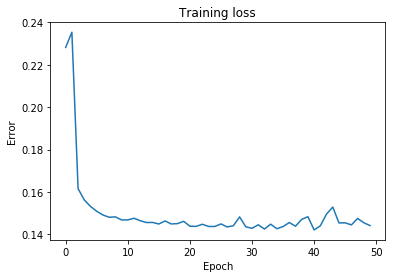

In [105]:
plt.plot(errors)
plt.title("Training loss")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

### 4- Testing

In [12]:
# Testing the RBM
test_loss = 0
s = 0.
for id_user in range(nb_user):
    v = base_train[id_user:id_user+1]
    vt = base_test[id_user:id_user+1]
    if len(vt[vt>0]) > 0:
        _,h = rbm.echan_h(v)
        _,v = rbm.echan_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>0] - v[vt>0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.2149)


## Recommendation phase

Once the learning is over we can make recommendations. We choose a user X, we apply the echan_h method followed by the echan_v method only once. We get the recommendations by selecting the movies with the highest score.

In [13]:
# utilisateur X 
id_userx = 92
vik = base[[id_userx]]
vit = base[[id_userx]]

test_loss = 0
if len(vit[vit>0]) > 0:
    _,hik = rbm.echan_h(vik)
    _,vik = rbm.echan_v(hik)
    test_loss += torch.mean(torch.abs(vit[vit>0] - vik[vit>0]))
#loss
print('loss recommandation : '+str(test_loss))


loss recommandation : tensor(0.2407)


In [14]:

rec = movies_df[movies_df['List Index'] < nb_movie]
a = np.asarray(vik)
a = a.transpose()
score = pd.DataFrame({'Recommandation': a[:,0]})
rec['Recommandation']=score
rec.head()


,MovieID,Title,Genres,List Index,Recommandation
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0.5
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1,0.5
2,3,Grumpier Old Men (1995),Comedy|Romance,2,0.5
3,4,Waiting to Exhale (1995),Comedy|Drama,3,0.5
4,5,Father of the Bride Part II (1995),Comedy,4,0.5


In [15]:

# Tous les films que l'utilisateur à déjà vu
movies_ux = fusion[(fusion['UserID'] == id_userx)]
movies_ux.head()


,MovieID,Title,Genres,List Index,UserID,Rating
29,1,Toy Story (1995),Animation|Children's|Comedy,0,92,4
2090,2,Jumanji (1995),Adventure|Children's|Fantasy,1,92,2
3733,6,Heat (1995),Action|Crime|Thriller,5,92,1
5122,8,Tom and Huck (1995),Adventure|Children's,7,92,3
8470,17,Sense and Sensibility (1995),Drama|Romance,16,92,4


In [16]:
movies_ux=movies_ux.drop('Title', axis=1).drop('Genres', axis=1).drop('UserID', axis=1)

In [24]:

# Fusioner
movies_ux1 = pd.merge(rec,movies_ux , on='MovieID', how='outer')

 
movies_ux1 = movies_ux1.drop('List Index_y', axis=1)

# Choisir les 20 films les plus recommnandés 
movies_ux1.sort_values(['Recommandation'], ascending=False).head(20)



,MovieID,Title,Genres,List Index_x,Recommandation,Rating
1249,1269,Arsenic and Old Lace (1944),Comedy|Mystery|Thriller,1249,1.000000,NaN
1191,1209,Once Upon a Time in the West (1969),Western,1191,1.000000,NaN
3348,3417,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi,3348,1.000000,NaN
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,1179,1.000000,5.0
3401,3470,Dersu Uzala (1974),Adventure|Drama,3401,1.000000,NaN
1219,1238,Local Hero (1983),Comedy,1219,1.000000,NaN
1567,1609,187 (1997),Drama,1567,1.000000,NaN
1244,1264,Diva (1981),Action|Drama|Mystery|Romance|Thriller,1244,1.000000,NaN
1286,1306,Until the End of the World (Bis ans Ende der W...,Drama|Sci-Fi,1286,1.000000,NaN
2570,2639,Mommie Dearest (1981),Drama,2570,0.999999,NaN
